In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.axes as axe
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time


# General CBCP Equilibrium Solver

## Quartic Polynomial Latency Functions

In [6]:
x_temp = np.array([0, 1, 2, 3, 4])
x_temp[-2:]

array([3, 4])

In [1]:
# Latency Function: a_4 x^4 + a_3 x^3 + a_2 x^2 + a_1 x + a_0

# def solve_CBCP_iter(v_ineligible_list, v_eligible_list, a = , num_iters = 1000, alpha_0 = ):
    
#     # TODO
    
#     return y_opt


def solve_CBCP_iter_11(tau, B, v_I, v_E, a = np.array([0, 1]), input_flow = 1, \
                       num_iters_max = 5000, error_bound = 1E-3, diffs_range = 10, \
                       y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0]) ):
    
    # Order of y_init: \hat y_1 E, \tilde y_1 E
    
    # Initialize y_el_fixed, y_in_fixed:
    y_el_fixed = y_init[0:3]
    y_in_fixed = y_init[-2:]
    
    for k in range(num_iters_max):
        
        # y_el: \hat y_1 E, \tilde y_1 E, y_2 E
        y_el_var = cp.Variable(3)
        # y_in: y_1 I, y_2 I
        y_in_var = cp.Variable(2)
        
        # Compute gradient:
        
        grad = np.zeros(5)
        grad[0] = a[1] * (y_el_var[0] + y_el_var[1] + y_in_var[0]) + a[0] + tau / v_E
        grad[1] = a[1] * (y_el_var[0] + y_el_var[1] + y_in_var[0]) + a[0]
        grad[2] = a[1] * (y_el_var[2] + y_in_var[1]) + a[0]
        grad[3] = a[1] * (y_el_var[0] + y_el_var[1] + y_in_var[0]) + a[0] + tau / v_I
        grad[4] = a[1] * (y_el_var[2] + y_in_var[1]) + a[0]
        
        constraints = []
        constraints += [y_el >= 0, y_in >= 0]
        constraints += [cp.sum(y_el) == 1, cp.sum(y_in) == 1]
        constraints += [y_el[1] * tau <= B]

        prob = cp.Problem(objective, constraints)

        # The optimal objective value is returned by `prob.solve()`.
        result = prob.solve()
        # The optimal value for x is stored in `x.value`.
        print("y_el.value:", y_el.value)
        print("y_in.value:", y_in.value)
        
        if max([-diffs_range:]) - min(-diffs_range:) <= error_bound: 
            break
    
    return y_opt

def solve_CBCP_direct_11(tau, B, v_I, v_E, a = np.array([1, 0]), input_flow = 1):

    # y_el: \hat y_1, \tilde y_1, y_2
    y_el = cp.Variable(3)
    # y_in: y_1, y_2
    y_in = cp.Variable(2)
    
    objective = cp.Minimize(0.5 * a[1] * (y_el[0] + y_el[1] + y_in[0])**2 \
                            + a[0] * (y_el[0] + y_el[1] + y_in[0]) \
                            + y_in[0] * tau / v_I + y_el[0] * tau / v_E \
                            + 0.5 * a[1] * (y_el[2] + y_in[1])**2 \
                            + a[0] * (y_el[2] + y_in[1]) )
    
    constraints = []
    constraints += [y_el >= 0, y_in >= 0]
    constraints += [cp.sum(y_el) == 1, cp.sum(y_in) == 1]
    constraints += [y_el[1] * tau <= B]
    
    prob = cp.Problem(objective, constraints)
    
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    # The optimal value for x is stored in `x.value`.
    print("y_el.value:", y_el.value)
    print("y_in.value:", y_in.value)

    return y_el.value, y_in.value


# Scratch Work:

In [4]:
x = cp.Variable(2)
y = cp.Variable(2)
v_fixed = np.array([0, 1])
objective = cp.Minimize(cp.sum_squares(x - y) + cp.sum_squares(x - v_fixed))
constraints = []
# for i in range(2):
#     constraints += [x[i] >= 2]
# constraints += [x[i] >=2 for i in range(2)]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print("x.value:", x.value)
print("y.value:", y.value)
print()


x.value: [-0.  1.]
y.value: [-0.  1.]



# Old Code Below:

# Budget vs Discount - Theory

## 1 Eligible group, 1 Ineligible group (Theory)

In [2]:
def F_11(val, ell, tau, alpha):
    return ell(val) + (1 - alpha) * tau - ell(2 - val)

def y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0, num_iters = 20):
    # Searches for y^\star satisfying ell(y^\star) + (1 - \alpha) \tau = ell(2 - y^\star)
    
    assert tau < ell(ub_init) - ell(lb_init), "We must have tau < ell(2.0) - ell(0.0), else is trivial."
    assert 0.0 <= alpha <= 1.0, "We must have 0.0 <= alpha <= 1.0"
    assert ell(lb_init) + (1.0 - alpha) * tau < ell(ub_init)
    
    lb = lb_init
    ub = ub_init
    mid_val = (lb + ub)/2
    
    for k in range(num_iters):
#         print("F:", F_11(mid_val, ell, tau, alpha))
#         print("lb:", lb)
#         print("ub:", ub)
#         print("mid_val:", mid_val)
#         print()
        
        if F_11(mid_val, ell, tau, alpha) < 0:
            lb = mid_val
        else:
            ub = mid_val
        mid_val = (lb + ub)/2
    
    return (lb + ub)/2

# def fixed_point_eqn():
    


In [3]:
t_1 = time.time()

ell = lambda x: x**4 / 16
# ell = lambda x: np.log(1 + np.exp(x))
# alpha = 0.0

# # Case 1: 
# tau = 0.4
# v_E = 1
# v_I = 1.25

# # Case 2: 
# tau = 0.7
# v_E = 1
# v_I = 1.25

# Case 3: 
tau = 0.7
v_E = 1
v_I = 2.5

num_alpha_grid_points = 100 # Should be even
alpha_vals = np.linspace(0, 1.0, num = num_alpha_grid_points + 1)

y_star_zero = y_star_11(ell, tau, alpha = 0.0, lb_init = 0.0, ub_init = 2.0)
# print("y_star_zero:", y_star_zero)

y_star_vals = np.array([y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0) for alpha in alpha_vals])
y_star_vals_budget = alpha_vals
index_max = max([k for k in list(range(num_alpha_grid_points)) if alpha_vals[k] <= 1 - v_E/v_I])
# print("index_min:", index_min)
# print("alpha_vals[index_min]:", alpha_vals[index_min])
# print("y_star_vals_budget:", y_star_vals_budget)
# print()

# print("y_star_vals:", y_star_vals)
# print()

y_star_vals_discount = np.copy(y_star_vals)
for k in range(y_star_vals_discount.shape[0]):
    if k <= index_max:
        y_star_vals_discount[k] = 0.0

tau_thresh_for_alpha_3 = 2 * v_E * (ell(1) - ell(1 - 1E-6)) / 1E-6
index_for_alpha_3 = max([k for k in list(range(num_alpha_grid_points)) if y_star_vals[k] >= alpha_vals[k] ])
alpha_3 = (y_star_vals[index_for_alpha_3] + y_star_vals[index_for_alpha_3 + 1])/2

# print("y_star_vals_budget:", y_star_vals_budget)

# print("y_star_vals_budget:", y_star_vals_budget)


t_2 = time.time()
print("Time:", t_2 - t_1)

Time: 0.005392313003540039


In [4]:
print("1 - v^E / v^I:", 1 - v_E/v_I)
print("alpha_3:", alpha_3)

1 - v^E / v^I: 0.6
alpha_3: 0.365936279296875


Text(0, 0.5, '$\\displaystyle y^C, y^D$')

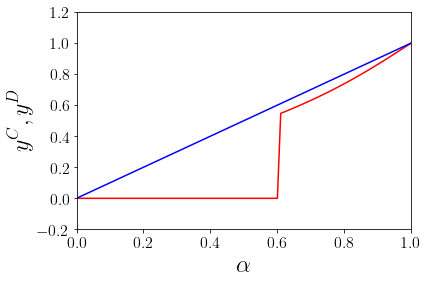

In [6]:
plt.rcParams['text.usetex'] = True
# plt.rcParams['text.usetex'] = False

plt.plot(alpha_vals, y_star_vals_discount, 'red')
plt.plot(alpha_vals, y_star_vals_budget, 'blue')
# plt.scatter(alpha_vals, y_star_vals_discount, marker = 'o', s = 0.5, color = 'purple')
# plt.scatter(alpha_vals, y_star_vals_budget, marker = 'o', s = 0.5, color = 'black')
plt.xlim([0, 1.0])
plt.ylim([-0.2, 1.2])

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel(r'$\displaystyle \alpha$', fontsize=24)
plt.ylabel(r'$\displaystyle y^C, y^D$', fontsize=24)
# plt.ylabel(r'$\displaystyle \ln(L^t - L^\star)$', fontsize=16)

# Scratch Work:

In [ ]:
# m_sample = gp.Model()
